**Test with Iris dataset and Test and train split function**

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X, y = iris.data, iris.target

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(X_train[0])
print(y_test[0])

(120, 4)
(30, 4)
(120,)
(30,)
[6.1 3.  4.6 1.4]
0


### Architecture definition

In [2]:
#define ANN architecture as a Torch NN Module

import torch.nn as nn

class ANN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.lin1 = nn.Linear(4, 10)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(10, 20)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(20, num_classes)
        
    def forward(self, x, debug=False):
        if debug : print(f'Shape de entrada: {x.shape}')
        x = self.lin1(x)
        if debug : print(f'Shape de entrada: {x.shape}')
        x = self.act1(x)
        if debug : print(f'Shape de entrada: {x.shape}')
        x = self.lin2(x)
        if debug : print(f'Shape de entrada: {x.shape}')
        x = self.act2(x)
        if debug : print(f'Shape de entrada: {x.shape}')
        y = self.lin3(x)
        if debug : print(f'Shape de entrada: {y.shape}')
        return y         

### Model analysis

In [3]:
import torch

if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}.")

net = ANN( num_classes=3 )
#net = ANN()

net = net.to(my_device)

a = torch.rand( (1, 4) )
a = a.to(my_device)
b = net( a , debug=True)

del a, b, net

Running on cpu.
Shape de entrada: torch.Size([1, 4])
Shape de entrada: torch.Size([1, 10])
Shape de entrada: torch.Size([1, 10])
Shape de entrada: torch.Size([1, 20])
Shape de entrada: torch.Size([1, 20])
Shape de entrada: torch.Size([1, 3])


In [4]:
from torchsummary import summary

net = ANN( num_classes=3 )

net = net.to(my_device)

summary(net, input_size=(1, 4), batch_size=1)

del net

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [1, 1, 10]              50
              ReLU-2                 [1, 1, 10]               0
            Linear-3                 [1, 1, 20]             220
              ReLU-4                 [1, 1, 20]               0
            Linear-5                  [1, 1, 3]              63
Total params: 333
Trainable params: 333
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Training functions

In [5]:
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

from torch.utils.data import TensorDataset, DataLoader

def train ( dataset, prefix=None, upper_bound=101.0, save=False, epochs=100, batch_based = False, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=True, lambda_reg=0 ) :
    
    num_classes = 3
    
    tensorboard_path = '/home/jose-roberto/Documents/Disciplinas/INF492/assignment/a4/train_runs/'
  
    net = ANN( num_classes )
    net.to(device)

    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=lambda_reg)
    criterion = nn.CrossEntropyLoss()

    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
    
    accuracies = []
    max_accuracy = -1.0  

    # Divisão do dataset em treino e teste
    data_loader = train_test_split( dataset.data,
                                     dataset.target,
                                     test_size=0.2,
                                     random_state=1 )
    
    train_x,test_x,train_label,test_label = data_loader
    
    train_x = torch.from_numpy(train_x).float()
    train_x = train_x.to(device)
    train_label = torch.from_numpy(train_label).float()
    train_label = train_label.to(device)
    
    test_x = torch.from_numpy(test_x).float()
    test_x = test_x.to(device)
    test_label = torch.from_numpy(test_label).float()
    test_label = test_label.to(device)

    if batch_based:
        train_set = TensorDataset(train_x, train_label)
        test_set = TensorDataset(test_x, test_label)

        train_dataloader = DataLoader(train_set, batch_size=4, shuffle=True)
        test_dataloader = DataLoader(test_set, batch_size=4, shuffle=False)

        train_dataloader_size = len(train_dataloader)
        test_dataloader_size = len(test_dataloader)

    writer.add_graph(net, train_x)
    
    for epoch in tqdm( range(epochs) , desc='Training epochs...' ) :
        
        if batch_based:
            accumulated_error_train = 0.0
            accumulated_error_test = 0.0
            
            train_accuracies = []
            test_accuracies = []

            net.train()
            for train_batch in train_dataloader:
                optimizer.zero_grad()

                train_x_batch , train_label_batch  = train_batch 
                        
                predict_y = net(train_x_batch)

                error = criterion(predict_y , train_label_batch.long())
                accumulated_error_train += error.item()

                error.backward()
                optimizer.step()

                # Accuracies:
                predict_ys = torch.max( predict_y, axis=1 )[1]
                correct    = torch.sum( predict_ys == train_label_batch )
                accuracy_train = correct/train_x.size(0)

                train_accuracies.append(accuracy_train)

            full_error_train = accumulated_error_train/train_dataloader_size

            avg_train_acurracie = sum(train_accuracies)/train_dataloader_size

            net.eval()
            for test_batch in test_dataloader:
                test_x_batch, test_label_batch = test_batch

                predict_y = net(test_x_batch)

                error = criterion(predict_y , test_label_batch.long())
                accumulated_error_test += error.item()

                accuracy_test = validate(net, test_x_batch, test_label_batch, device=device)
                test_accuracies.append(accuracy_test)

            full_error_test = accumulated_error_test/test_dataloader_size

            avg_test_acurracie = sum(test_accuracies)/test_dataloader_size
            
            # Tensor board writing
            writer.add_scalar( 'Loss/train', full_error_train, epoch )
            writer.add_scalar( 'Loss/test', full_error_test, epoch )
            writer.add_scalar( 'Accuracy/train', avg_train_acurracie, epoch )
            writer.add_scalar( 'Accuracy/test', avg_test_acurracie, epoch )

            if layers2tensorboard :
                plot_layers( net, writer, epoch )

            # Test model
            if avg_test_acurracie > max_accuracy:
                best_model = copy.deepcopy(net)
                max_accuracy = avg_test_acurracie
                print(f'Saving the best model at epoch {epoch+1:3d} ' + 
                        f'with Accuracy: {avg_test_acurracie:8.4f}%')
        
            if debug : print( f'Epoch: {epoch+1:3d} |' 
                            + f'Accuracy Test: {avg_test_acurracie:3.4f}%' )

            if avg_test_acurracie > upper_bound :
                break
        else:
            # Set Pytorch variables
            net.train()
            optimizer.zero_grad()
                                
            # Forward step
            predict_y = net( train_x )
            
            # Loss
            error = criterion( predict_y , train_label.long() )

            # Back propagation
            error.backward()
            optimizer.step()

            # Accuracies:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum( predict_ys == train_label )
            accuracy_train = correct/train_x.size(0)
            
            accuracy_test = validate(net, test_x, test_label, device=device)
            accuracies.append(accuracy_test)
            
            # Tensor board writing
            writer.add_scalar( 'Loss/train', error.item(), epoch )
            writer.add_scalar( 'Accuracy/train', accuracy_train, epoch )
            writer.add_scalar( 'Accuracy/test', accuracy_test, epoch )

            if layers2tensorboard :
                plot_layers( net, writer, epoch )

            # Test model
            if accuracy_test > max_accuracy:
                best_model = copy.deepcopy(net)
                max_accuracy = accuracy_test
                print(f'Saving the best model at epoch {epoch+1:3d} ' + 
                        f'with Accuracy: {accuracy_test:8.4f}%')
        
            if debug : print( f'Epoch: {epoch+1:3d} |' 
                            + f'Accuracy Test: {accuracy_test:3.4f}%' )

            if accuracy_test > upper_bound :
                break
   
    if save : 
        models_path = '/home/jose-roberto/Documents/Disciplinas/INF492/assignment/a4/models/'
        path = f'{models_path}{prefix}-{max_accuracy:.2f}.pkl'
        torch.save( best_model, path )
        print( f'Model saved in: {path}' )
  
    plt.figure(figsize=(16, 8))
    plt.plot(test_accuracies if batch_based else accuracies)

    writer.flush()
    writer.close()

    return best_model

In [6]:
def validate ( model , test_x, test_label , device='cpu') :

    model.eval()

    predict_y = model( test_x ).detach()
    predict_ys = torch.max( predict_y, axis=1 )[1]
    correct = torch.sum(predict_ys == test_label)
  
    return correct.to('cpu').numpy()*100./test_x.size(0)

In [7]:
def plot_layers ( net , writer, epoch ) :
    layers = list(net.modules())

    layer_id = 1
    for layer in layers:
        if isinstance(layer, nn.Linear) :
            writer.add_histogram(f'Bias/linear-{layer_id}', layer.bias, epoch )
            writer.add_histogram(f'Weight/linear-{layer_id}', layer.weight, epoch )
            writer.add_histogram(f'Grad/linear-{layer_id}', layer.weight.grad, epoch )
            layer_id += 1

### Run the training phase

In [8]:
from sklearn.datasets import load_iris

if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")
    
print(f"Running on {my_device.type}")
    
dataset = 'Iris'
epochs = 500
lr = 1e-1
lambda_reg = 1e-4
standard_prefix = 'ANN-{}-e-{}-lr-{}'.format(dataset, epochs, lr)
batch_based_prefix = 'bANN-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

iris = load_iris()
dataset = iris

Running on cpu


Training epochs...:   1%|          | 3/500 [00:00<00:20, 23.85it/s]

Saving the best model at epoch   1 with Accuracy:  20.0000%


Training epochs...:   2%|▏         | 9/500 [00:00<00:20, 23.79it/s]

Saving the best model at epoch   6 with Accuracy:  40.0000%
Saving the best model at epoch   7 with Accuracy:  56.6667%


Training epochs...:   5%|▌         | 25/500 [00:00<00:15, 30.77it/s]

Saving the best model at epoch  21 with Accuracy:  93.3333%


Training epochs...:  47%|████▋     | 237/500 [00:09<00:10, 24.08it/s]

Saving the best model at epoch 233 with Accuracy:  96.6667%
Saving the best model at epoch 235 with Accuracy: 100.0000%


Training epochs...: 100%|██████████| 500/500 [00:20<00:00, 23.92it/s]


Model saved in: /home/jose-roberto/Documents/Disciplinas/INF492/assignment/a4/models/ANN-Iris-e-500-lr-0.1-20250421_231716-100.00.pkl


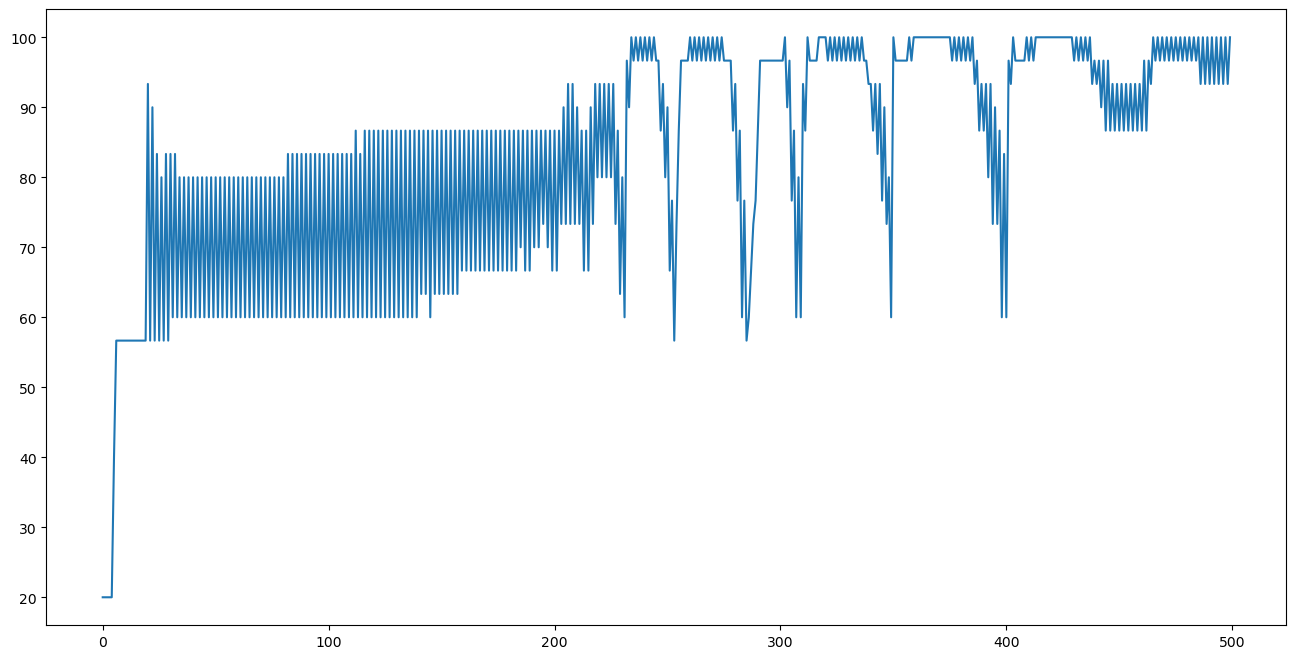

In [10]:
net = train( dataset=dataset, epochs=epochs, device=my_device, 
            upper_bound=101.0, lr=lr, lambda_reg=lambda_reg,
            layers2tensorboard=True, save=True, prefix=standard_prefix
           )

Training epochs...:   0%|          | 1/500 [00:00<00:56,  8.85it/s]

Saving the best model at epoch   1 with Accuracy:  56.2500%


Training epochs...:   1%|          | 4/500 [00:00<01:19,  6.26it/s]

Saving the best model at epoch   3 with Accuracy: 100.0000%


Training epochs...: 100%|██████████| 500/500 [00:47<00:00, 10.64it/s]


Model saved in: /home/jose-roberto/Documents/Disciplinas/INF492/assignment/a4/models/bANN-Iris-e-500-lr-0.1-20250421_231737-100.00.pkl


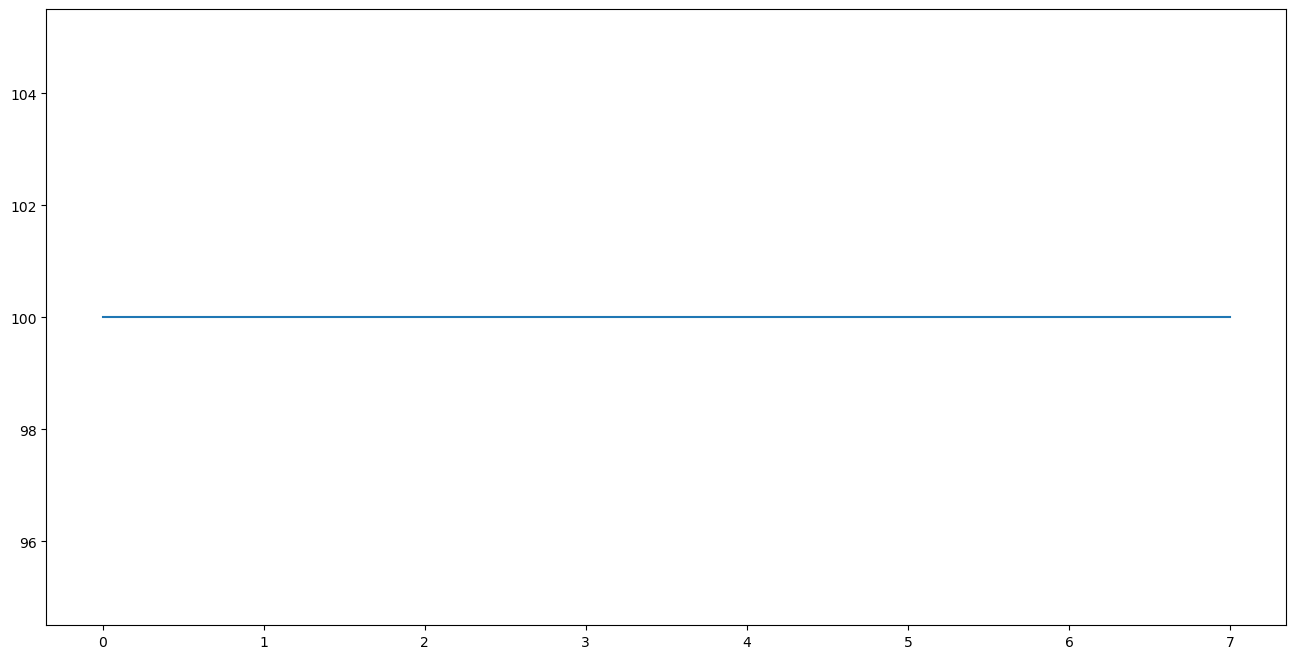

In [11]:
net_b = train( dataset=dataset, epochs=epochs, batch_based=True, device=my_device, 
            upper_bound=101.0, lr=lr, lambda_reg=lambda_reg,
            layers2tensorboard=True, save=True, prefix=batch_based_prefix
           )